In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re
from pyattck import Attck
import requests
from stix2 import MemoryStore, Filter
import seaborn as sns

In [2]:
def GenerateAprioriLists():
    # some data comes from this dataset with TTPs
    df = pd.read_csv("Categorized_Adversary_TTPs.csv") # sample dataset of attacks


    # more data is gained by using attck data from actors and malware TTPs
    attack = Attck()

    actors = {}
    for actor in attack.enterprise.actors:
        actors[actor.id] = actor
    malwares = attack.enterprise.malwares + attack.enterprise.tools
    ttpLists = []
    for malware in malwares:
        ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

    # to use the apriori we need to generate a list of lists
    aprList = ttpLists
    for row in df.values:
        aprList.append((row[13].strip('][').split(', ')))
    return aprList

def abstractTTPs(ttpList):
    for i in range(0,len(ttpList)):
        ttpList[i] = [re.sub(r'\.[0-9]+', '', ttp) for ttp in ttpList[i]]
    return ttpList 

In [63]:
def GenerateTechniqueMap():
    ttpMap = {}
    attack = Attck()
    for tactic in attack.enterprise.tactics:
        for technique in tactic.techniques:  
            ttpMap[technique.id] = tactic.name
            for subtechnique in technique.subtechniques:
                ttpMap[subtechnique.id] = tactic.name
    return ttpMap

In [64]:
sttps = GenerateAprioriLists()
attps = abstractTTPs(GenerateAprioriLists())
ttpMap = GenerateTechniqueMap()

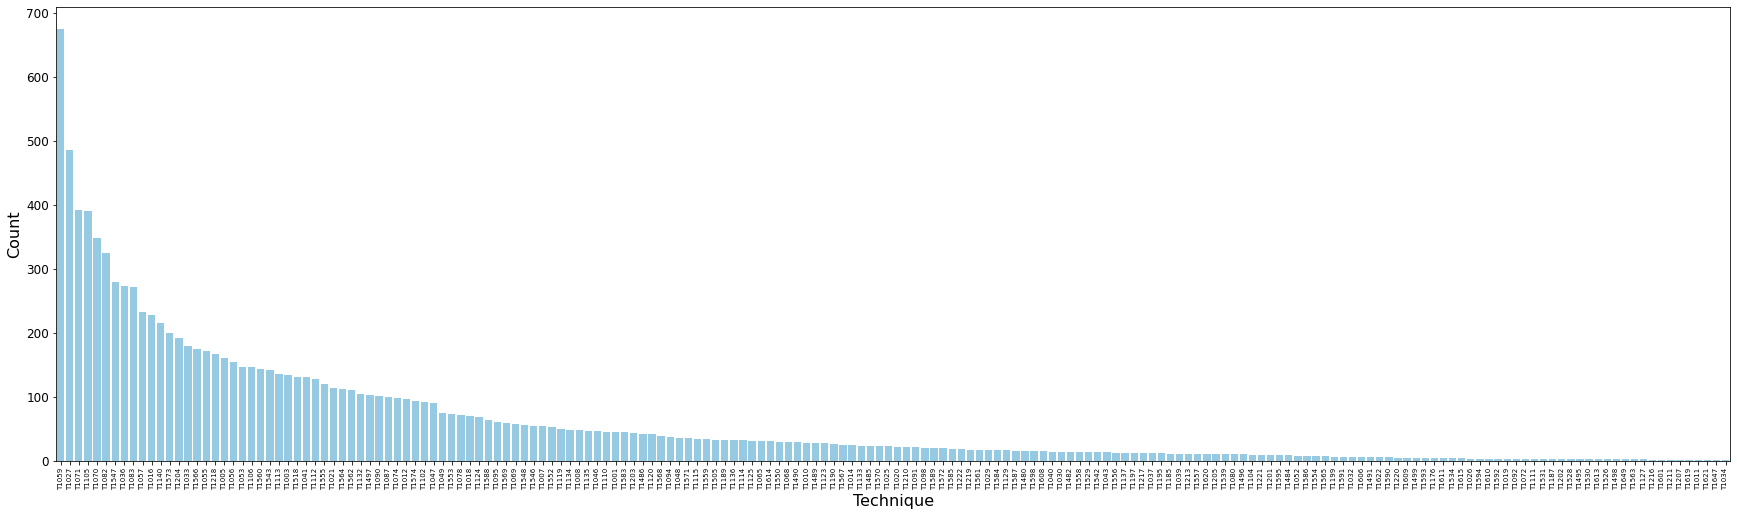

In [172]:
# Visualize distribution of TTPs 

data = attps
#flatten the list of lists
data = {"TTPs": [item[1:-1] for sublist in data for item in sublist if item]}

tactics = []
for ttp in data["TTPs"]:
    tactics.append(ttpMap[ttp])

data["Tactics"] = tactics

df = pd.DataFrame(data)
df = df.groupby(['TTPs', "Tactics"]).size().reset_index(name='counts')
df = df.sort_values(by='counts',ascending=False)

plt.figure(figsize=(30,10))

ax = sns.barplot(x='TTPs', y='counts', data=df, color="#89CFF0")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Technique', fontsize=16)
ax.tick_params(axis='x', which="major", labelsize=7)
ax.tick_params(axis='y', labelsize=12)
plt.savefig("DataHistogram.pdf")

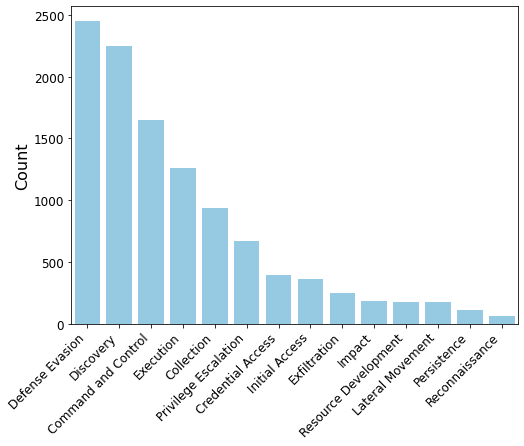

In [156]:
# Visualize distribution of tactics

data = sttps
#flatten the list of lists
data = {"TTPs": [item[1:-1] for sublist in data for item in sublist if item]}

tactics = []
for ttp in data["TTPs"]:
    tactics.append(ttpMap[ttp])

data["Tactics"] = tactics

df = pd.DataFrame(data)
df = df.groupby(['Tactics']).size().reset_index(name='counts')
df = df.sort_values(by='counts',ascending=False)

plt.figure(figsize=(8,7))

ax = sns.barplot(x='Tactics', y='counts', data=df, color="#89CFF0")
ax.tick_params(axis='both', labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.ylabel('Count', fontsize=16)
plt.xlabel('', fontsize=16)
plt.subplots_adjust(bottom=0.25)
plt.savefig("TacticHistogram.pdf")

In [ ]:
plt.savefig("dataHistogram.pdf")

<AxesSubplot:xlabel='TTPs'>

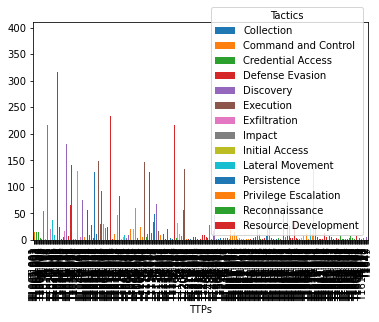

In [81]:
df.pivot_table(values='counts', index='TTPs', columns='Tactics', fill_value=0).plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Tactics', ylabel='TTPs'>

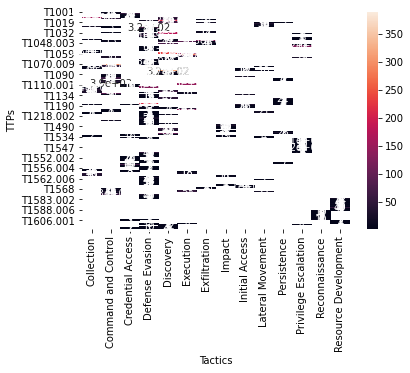

In [82]:
df_pivot = df.pivot(index='TTPs', columns='Tactics', values='counts')
sns.heatmap(df_pivot, annot=True)